In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from astropy import units as u
from astropy import constants as c
from astropy.cosmology import Planck18 as cosmo
from scipy import interpolate
from tqdm import tqdm

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial

sys.path.append(os.environ['DM21CM_DIR'])
from preprocessing.accretion import *
from preprocessing.halo import *
# from dm21cm.preprocessing.hmf import *
from dm21cm.utils import load_h5_dict
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory import physics as dh_phys

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/halomod/halo_exclusion.py:18: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  warnings.warn(


# Model

In [2]:
z = 10
m_PBH = 100 # [M_sun]
c_in = 23 # [km/s]

# $f_\mathrm{coll}$

In [5]:
hmf_data = load_h5_dict("/n/holystore01/LABS/iaifi_lab/Users/yitians/dm21cm/data/hmf/hmf.h5")
m_s = hmf_data['m'] # [Msun]
z_s = hmf_data['z'] # [1]
dndM_table = hmf_data['st'] # [1 / cMpc^3 Msun]
dndM = interpolate.interp1d(z_s, dndM_table, axis=0)(z)

Text(0, 0.5, '$d n / d \\log M$')

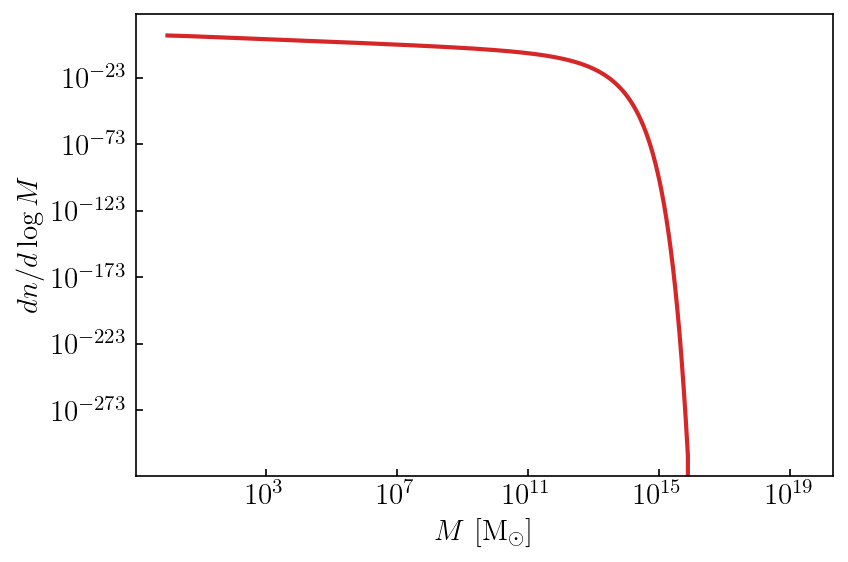

In [6]:
plt.plot(m_s, m_s * dndM)
plt.loglog()
plt.xlabel(r'$M$ [M$_\odot$]')
plt.ylabel(r'$d n / d \log M$')

In [7]:
# f_coll
rho_coll = np.trapz(m_s * dndM, m_s)
# conformal matter density [M_sun / cMpc^3]
RHO_M = cosmo.Om0 * cosmo.critical_density0.to(u.M_sun / u.Mpc**3).value
f_coll = rho_coll / RHO_M # [1]

print(f_coll)

0.29565250948826866


In [9]:
# halo scale radius
z = 10
m_halo = 1e8 # [M_sun]
c_halo = cmz(m_halo, z)
print(f"c_halo = {c_halo:.2f}")
rho_s, r_s, r_delta = nfw_info(m_halo, 2.9, z)
print(r_s, 'pc')

c_halo = 4.10
452.4477790306772 pc


# Cosmo PBH

In [11]:
#--- taken from dm21cm.preprocessing.accretion.PBHAccretionModel ---
rho_inf = (cosmo.critical_density(z) * cosmo.Ob(z)).to(u.g/u.cm**3) # [g/cm^3]
T_K = dh_phys.Tm_std(1+z) # [eV]
x_e = dh_phys.xHII_std(1+z)
c_inf = np.sqrt(5/3 * (1+x_e) * T_K * u.eV / c.m_p).to(u.km/u.s).value # [km/s]
v_cb = v_cb_cosmo(z) # [km/s]
#------

print(f'rho_inf = {rho_inf:.3e}')
print(f'rho_inf/m_p = {(rho_inf / c.m_p).to(u.cm**-3):.3e}')
print(f'n_B = {phys.n_B * (1+z)**3:.3e} 1 / cm3')
print(f'n_A = {phys.n_A * (1+z)**3:.3e} 1 / cm3')
print(f'T_K = {(T_K * u.eV / c.k_B).to(u.K):.3f}')
print(f'x_e = {x_e:.3e}')
print(f'c_inf = {c_inf:.3f} km/s')
print(f'v_cb = {v_cb:.3f} km/s')

v_R, v_D = v_R_v_D(c_in, c_inf)
rho_in, v_in = rho_in_v_in(rho_inf.value, v_cb, c_in, c_inf)

print()
print(f'v_R = {v_R:.3f} km/s | v_D = {v_D:.3f} km/s')
print(f'rho_in = {rho_in:.3e} g/cm^3')
print(f'rho_in/m_p * A_per_B = {phys.A_per_B * (rho_in * u.g/u.cm**3 / c.m_p).to(u.cm**-3):.3e}')
print(f'v_in = {v_in:.3f} km/s')

mdot = 4 * np.pi * (rho_in*u.g/u.cm**3) * (c.G**2 * (m_PBH*u.M_sun)**2) / (v_in**2 + c_in**2)**(3/2) / (u.km/u.s)**3
mdot = mdot.to(u.Msun/u.yr)
print(f'acc rate = {mdot:.3e}')

l = L_ADAF(mdot.value, m_PBH)
print(f'L_ADAF = {l:.3e} solMass / yr')
print(f'L_ADAF = {(l*u.Msun/u.yr*c.c**2).to(u.erg/u.s):.3e}')
print(f'epsilon = {l / mdot.value:.3e}')

rho_inf = 5.605e-28 g / cm3
rho_inf/m_p = 3.351e-04 1 / cm3
n_B = 3.351e-04 1 / cm3
n_A = 2.735e-04 1 / cm3
T_K = 2.601 K
x_e = 1.971e-04
c_inf = 0.189 km/s
v_cb = 0.330 km/s

v_R = 45.999 km/s | v_D = 0.001 km/s
rho_in = 7.665e-32 g/cm^3
rho_in/m_p * A_per_B = 3.740e-08 1 / cm3
v_in = 23.000 km/s
acc rate = 7.824e-20 solMass / yr
L_ADAF = 1.642e-27 solMass / yr
L_ADAF = 9.299e+19 erg / s
epsilon = 2.099e-08


# Halo PBH

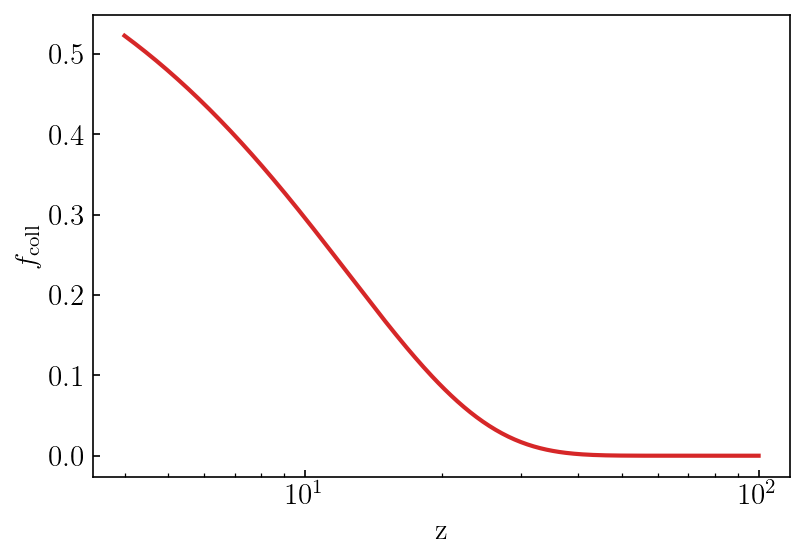

In [16]:
f_coll_list = []

for i_z, z, in enumerate(z_s):
    dndM = dndM_table[i_z]
    f_coll = np.trapz(m_s * dndM, m_s)  / RHO_M
    f_coll_list.append(f_coll)

f_coll_list = np.array(f_coll_list)
plt.plot(z_s, f_coll_list)
plt.xlabel('z')
plt.ylabel(r'$f_{\rm coll}$')
plt.xscale('log')